In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from scandataset import SCANDataset
from scandataloader import SCANDataLoader
from transformer import Transformer
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from hyperparam_config.hyperparam_exp23 import *

In [2]:
device = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')

device

'cpu'

In [3]:
MAX_LEN = 50
NR_REPS = 5
NR_NUM = 6

src_vocab = [
    '<PAD>',
    '<BOS>',
    '<EOS>',
    'walk',
    'look',
    'run',
    'jump',
    'turn',
    'left',
    'right',
    'and',
    'after',
    'opposite',
    'twice',
    'thrice',
    'around',
]

tgt_vocab = [
    '<PAD>',
    '<BOS>',
    '<EOS>',
    'I_WALK',
    'I_RUN',
    'I_JUMP',
    'I_LOOK',
    'I_TURN_RIGHT',
    'I_TURN_LEFT'
]

def list_to_dict(lst):
    return {k: v for v, k in enumerate(lst)}

src_vocab = list_to_dict(src_vocab)
tgt_vocab = list_to_dict(tgt_vocab)

scandataloader = SCANDataLoader()
data = []

data.append((
    scandataloader.load_file_path(
        os.path.join('data', 'add_prim_split', f'tasks_train_addprim_turn_left.txt')
    ),
    scandataloader.load_file_path(
        os.path.join('data', 'add_prim_split', f'tasks_test_addprim_turn_left.txt')
    )
))

data.append((
    scandataloader.load_file_path(
        os.path.join('data', 'add_prim_split', f'tasks_train_addprim_jump.txt')
    ),
    scandataloader.load_file_path(
        os.path.join('data', 'add_prim_split', f'tasks_test_addprim_jump.txt')
    )
))

for exponent in range(NR_NUM):
    pow2 = 2**exponent
    train_paths = []
    test_paths = []
    for i in range(1, NR_REPS + 1):
        data.append((
            scandataloader.load_file_path(os.path.join(
                'data',
                'add_prim_split',
                'with_additional_examples',
                f'tasks_train_addprim_complex_jump_num{pow2}_rep{i}.txt')
        ),
            scandataloader.load_file_path(os.path.join(
                'data',
                'add_prim_split',
                'with_additional_examples',
                f'tasks_test_addprim_complex_jump_num{pow2}_rep{i}.txt')
        )
        ))


In [4]:
def train_loop(model, optimizer, criterion, dataloader, epochs):
    model.train()

    for epoch in tqdm.tqdm(range(epochs)):
        total_loss = 0
        for batch in dataloader:
            src = batch['src'].to(device)
            tgt = batch['tgt'].to(device)

            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            output = model(src, tgt_input)

            output = output.view(-1, output.shape[-1])
            tgt_output = tgt_output.reshape(-1)

            loss = criterion(output, tgt_output)

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch + 1}, Loss: {total_loss/len(dataloader):.4f}")

In [37]:
def eval_loop(model, dataloader):
    model.eval()

    special_tokens = [tgt_vocab['<PAD>'], tgt_vocab['<BOS>'], tgt_vocab['<EOS>']]

    start_token = tgt_vocab['<BOS>']
    end_token = tgt_vocab['<EOS>']

    total_tokens = 0
    correct_tokens = 0
    total_seq = 0
    correct_seq = 0

    with torch.no_grad():
        for batch in dataloader:
            src = batch['src'].to(device)
            tgt = batch['tgt'].to(device)

            output = model.predict(src, start_token, end_token, MAX_LEN)

            for i in range(output.size(0)):
                tgt_tokens = tgt[i].cpu().numpy()
                pred_tokens = output[i].cpu().numpy()

                for t, p in zip(tgt_tokens, pred_tokens):
                    if t not in special_tokens:
                        total_tokens += 1
                        if t == p:
                            correct_tokens += 1

                if all(t == p for t, p in zip(tgt_tokens, pred_tokens) if t not in special_tokens):
                    correct_seq += 1
                total_seq += 1

    token_accuracy = correct_tokens / total_tokens
    seq_accuracy = correct_seq / total_seq

    return token_accuracy, seq_accuracy


def eval_loop_new_seq_calc(model, dataloader):
    model.eval()

    special_tokens = [tgt_vocab['<PAD>'], tgt_vocab['<BOS>'], tgt_vocab['<EOS>']]

    start_token = tgt_vocab['<BOS>']
    end_token = tgt_vocab['<EOS>']

    total_tokens = 0
    correct_tokens = 0
    total_seq = 0
    correct_seq = 0

    with torch.no_grad():
        for batch in dataloader:
            src = batch['src'].to(device)
            tgt = batch['tgt'].to(device)

            output = model.predict(src, start_token, end_token, MAX_LEN)

            for i in range(output.size(0)):
                tgt_tokens = tgt[i].cpu().numpy()
                pred_tokens = output[i].cpu().numpy()

                for t, p in zip(tgt_tokens, pred_tokens):
                    if t not in special_tokens:
                        total_tokens += 1
                        if t == p:
                            correct_tokens += 1
                    if p == tgt_vocab['<EOS>']:
                        break

                tgt_seq = tgt_tokens.tolist()
                pred_seq = pred_tokens.tolist()
                if tgt_vocab['<PAD>'] in pred_seq:
                    pred_seq = pred_seq[:pred_seq.index(tgt_vocab['<PAD>']) + 1]
                if tgt_vocab['<PAD>'] in tgt_seq:
                    tgt_seq = tgt_seq[:tgt_seq.index(tgt_vocab['<PAD>']) + 1]

                pred_seq = [token for token in pred_seq if token not in special_tokens]
                tgt_seq = [token for token in tgt_seq if token not in special_tokens]
                if pred_seq == tgt_seq:
                    correct_seq += 1
                total_seq += 1

    token_accuracy = correct_tokens / total_tokens
    seq_accuracy = correct_seq / total_seq

    return token_accuracy, seq_accuracy

In [39]:
epochs = 2
token_accuracies = []
seq_accuracies = []

for i in range(len(data)):
    train_data, test_data = data[i]

    dataset_train = SCANDataset(
        data=train_data,
        src_vocab=src_vocab,
        tgt_vocab=tgt_vocab,
        max_len=MAX_LEN,
    )

    dataset_test = SCANDataset(
        data=test_data,
        src_vocab=src_vocab,
        tgt_vocab=tgt_vocab,
        max_len=MAX_LEN,
    )

    dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

    model = Transformer(
        src_vocab_size=len(src_vocab),
        tgt_vocab_size=len(tgt_vocab),
        src_pad_idx=src_vocab['<PAD>'],
        tgt_pad_idx=tgt_vocab['<PAD>'],
        emb_dim=EMB_DIM,
        num_layers=N_LAYERS,
        num_heads=N_HEADS,
        forward_dim=FORWARD_DIM,
        dropout=DROPOUT,
        max_len=MAX_LEN,
    ).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab['<PAD>'])

    train_loop(model, optimizer, criterion, dataloader_train, epochs)

    token_accuracy, seq_accuracy = eval_loop_new_seq_calc(model, dataloader_test)

    print(f'Token-level accuracy: {token_accuracy}, Sequence-level accuracy: {seq_accuracy}')

    token_accuracies.append(token_accuracy * 100)
    seq_accuracies.append(seq_accuracy * 100)


 50%|█████     | 1/2 [02:53<02:53, 173.85s/it]

Epoch 1, Loss: 0.5285


100%|██████████| 2/2 [06:23<00:00, 191.70s/it]

Epoch 2, Loss: 0.1489


Token-level accuracy: 0.81243272335845, Sequence-level accuracy: 0.18543046357615894


 50%|█████     | 1/2 [01:32<01:32, 92.88s/it]

Epoch 1, Loss: 0.5886


100%|██████████| 2/2 [03:13<00:00, 96.79s/it]

Epoch 2, Loss: 0.2890


KeyboardInterrupt: 

In [23]:
# Results using the old function for calculating seq accuracy
copy_token_accuracies = [78.81773399014779, 62.262894591587305, 70.46659364731654, 70.14518658710756, 64.26211984473981, 68.89979406738817, 64.09063428225956, 71.74059758267379, 59.11671924290221, 79.80842542525875, 65.53410395505972, 68.04147202916714, 83.28965934287442, 74.1396082555541, 75.70957732157571, 68.85787669731847, 76.83108593873293, 76.61998263599611, 79.51707860633658, 77.60822283028135, 71.89763738094821, 82.88473175993896, 83.22130549771111, 86.11054976145081, 80.5183175748637, 75.8443633044272, 71.1979363171333, 91.7868360622564, 84.36238600687696, 85.81293875468445, 93.76941284129204, 89.24653681175727]
copy_seq_accuracies = [58.02980132450332, 1.6480664417337139, 9.513303049967552, 4.243997404282933, 0.6878650227125244, 9.305645684620377, 1.6872160934458142, 12.071651090342678, 10.968328141225339, 26.375908618899274, 3.7123572170301142, 7.801142263759086, 41.05427161776162, 21.78654894832511, 18.59257335756946, 15.255777720072707, 22.15009088548429, 21.434138737334372, 26.214601195115616, 25.26630293582749, 13.990646921278255, 29.94284229670044, 37.16514954486346, 48.20546163849155, 33.5110533159948, 24.616384915474644, 17.88036410923277, 68.17826426896012, 42.5983841542872, 49.400573364607766, 65.92389887933281, 61.206671879072196]

# Results using the new function for calculating seq accuracy
# copy_token_accuracies = [78.7064409208994, 63.74622083840982, 61.76993215349822, 65.6691370567585, 65.80285415568284, 72.13497833327365, 70.29064185278573, 69.88435507079032, 70.94328776474393, 75.14939358579966, 65.06540369869192, 73.73778761142525, 89.95041322314049, 74.65900154567888, 75.55477312532727, 69.44357485935082, 72.92866361087624, 79.71945242521548, 75.32793897483425, 86.34475736220156, 86.70959774170784, 84.99373549029, 81.94467997750783, 87.39805499960323, 88.39509488005729, 81.09679646757401, 85.7117632517569, 88.29418869950342, 90.05352919208266, 90.49847135451283, 89.45687183661913, 90.30675822573374]
# copy_seq_accuracies = [18.211920529801322, 0.11679211004412147, 4.879948085658663, 1.3757300454250487, 3.8157040882543805, 5.100584036340039, 3.335496430889033, 4.854620976116304, 8.37227414330218, 3.790238836967809, 2.2066458982346835, 7.930944963655244, 38.96390547909634, 13.645806284082058, 8.439366398338095, 7.517527914827317, 3.1680083095299927, 14.549233567160302, 6.170433878929591, 19.550532605871656, 19.75837879968823, 11.678358015068849, 18.634590377113135, 17.061118335500648, 21.690507152145642, 19.583875162548765, 28.296488946684008, 33.20302319520459, 37.75084701589784, 33.93275996872557, 25.658066197550166, 34.284597341673184]

In [24]:
aggregated_token_accuracies = [copy_token_accuracies[1]] * (NR_NUM + 1)
aggregated_seq_accuracies = [copy_seq_accuracies[1]] * (NR_NUM + 1)

# loop through all the nums to calculate average over reps
for i in range(NR_NUM):
    acc_per_num = sum(copy_token_accuracies[(i * NR_REPS + 2):(i * NR_REPS + 2 + NR_REPS)])
    aggregated_token_accuracies[i + 1] += acc_per_num
    aggregated_token_accuracies[i + 1] = aggregated_token_accuracies[i + 1] // (NR_REPS + 1)

    seq_per_num = sum(copy_seq_accuracies[(i * NR_REPS + 2):(i * NR_REPS + 2 + NR_REPS)])
    aggregated_seq_accuracies[i + 1] += seq_per_num
    aggregated_seq_accuracies[i + 1] = aggregated_seq_accuracies[i + 1] // (NR_REPS + 1)

In [25]:
def plot_exp3_acc(token_accuracies, seq_accuracies):

    X = ['0', '1', '2', '4', '8', '16', '32']

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].bar(X, token_accuracies, color='royalblue')
    axes[0].set_title("Token-Level Accuracy")
    axes[0].set_xlabel("Number of Composed Commands Used For Training")
    axes[0].set_ylabel("Accuracy on new commands (%)")
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)

    axes[1].bar(X, seq_accuracies, color='royalblue')
    axes[1].set_title("Sequence-Level Accuracy")
    axes[1].set_xlabel("Number of Composed Commands Used For Training")
    axes[1].set_ylabel("Accuracy on New Commands (%)")
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)

    plt.savefig('img//experiment3_average.png')
    plt.tight_layout()
    plt.show()

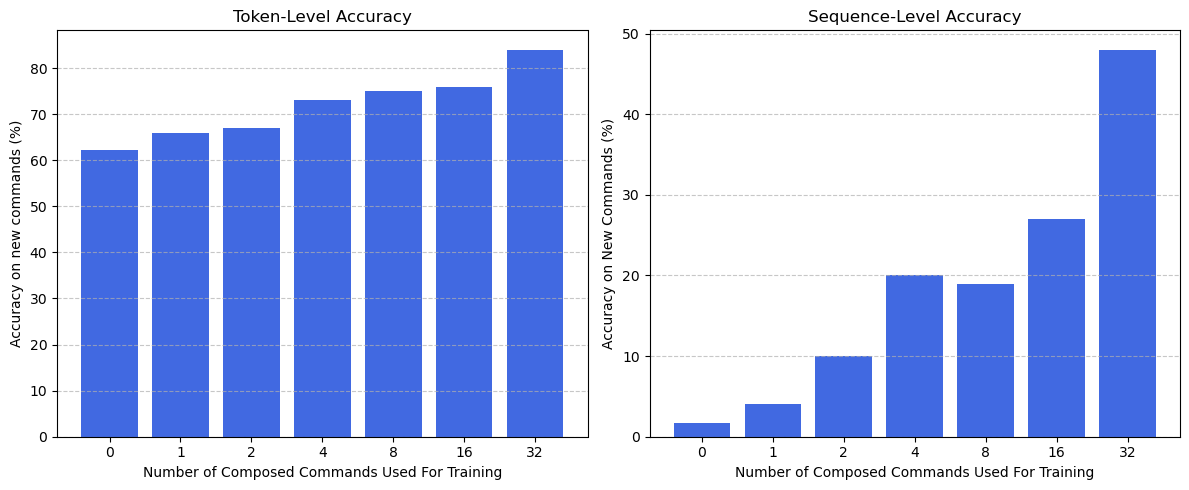

In [26]:
plot_exp3_acc(aggregated_token_accuracies, aggregated_seq_accuracies)